In [1]:
import numpy as np
import matplotlib
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

# Fidelity

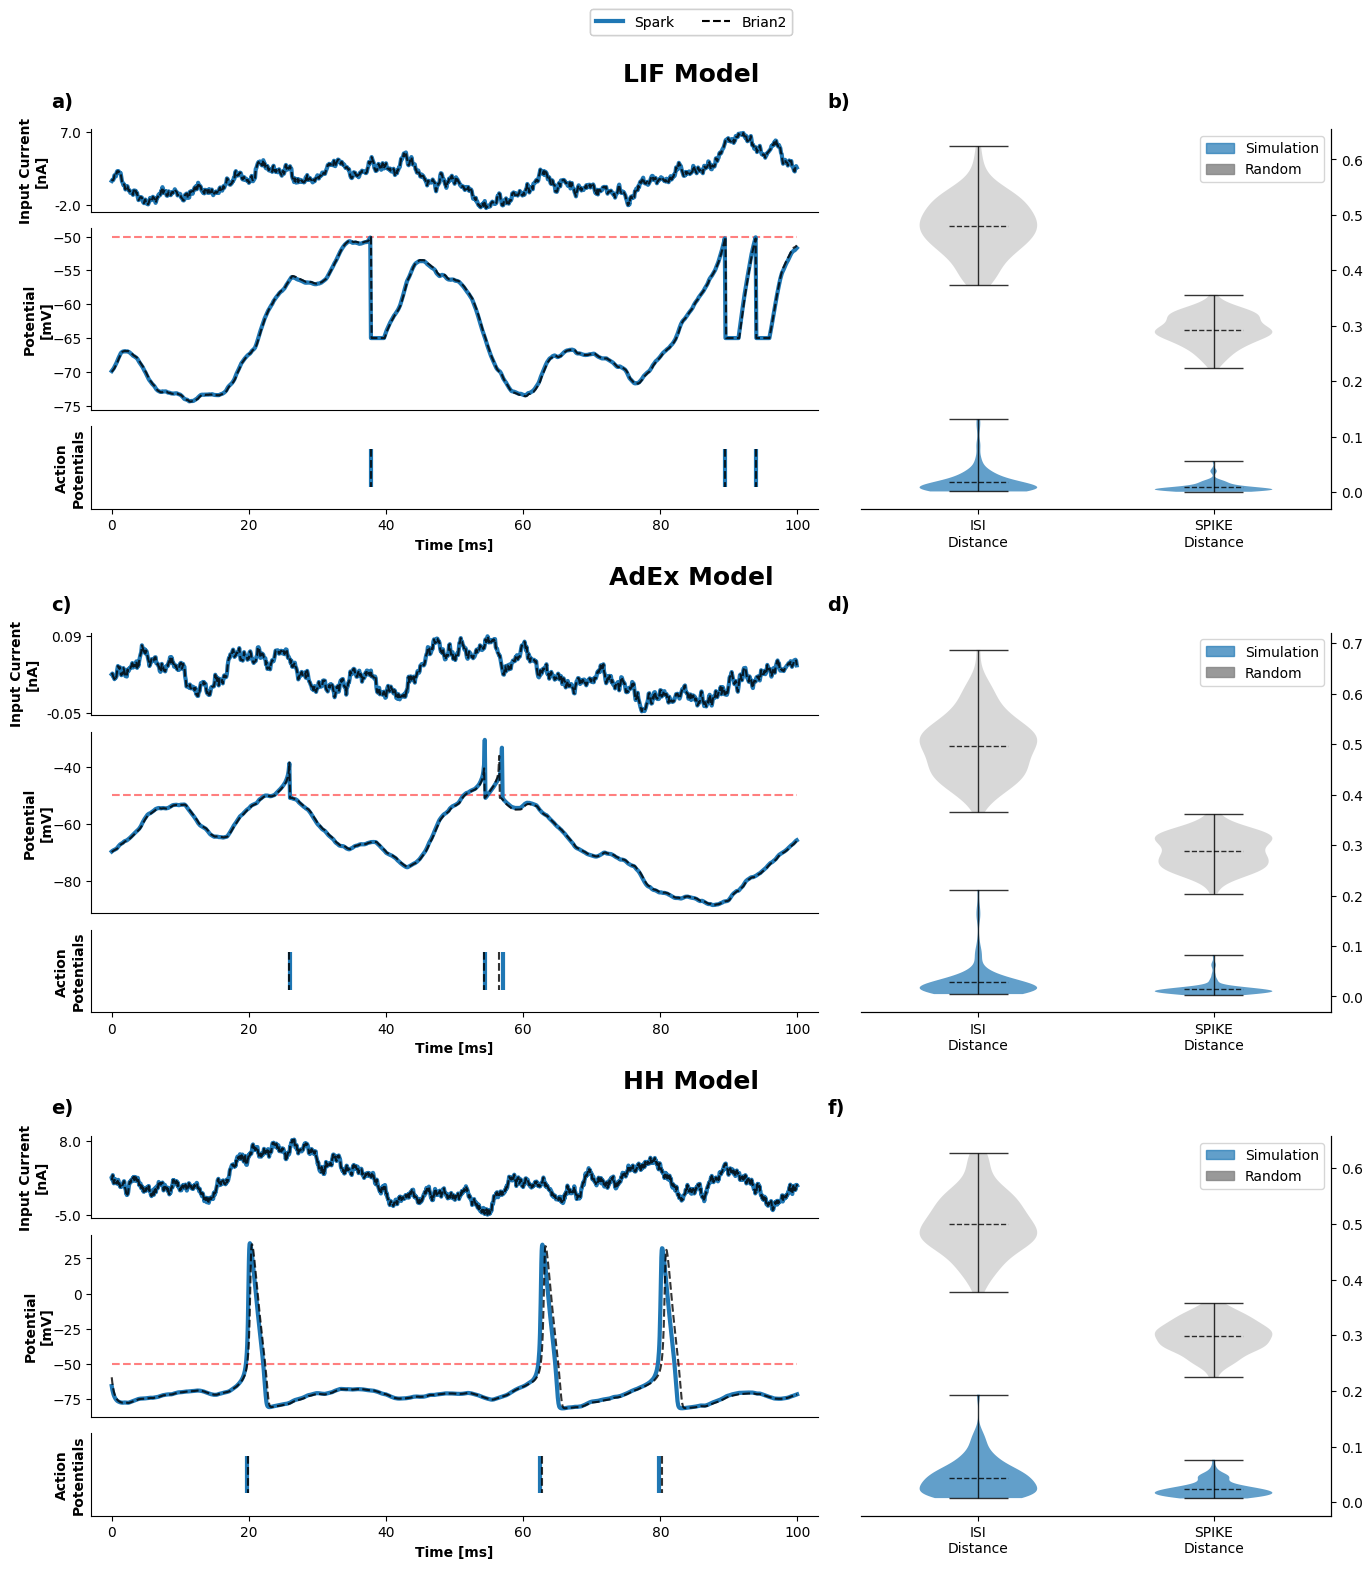

In [212]:
def populate_subfigure(
		subfig, title, subfig_index, input_current, firing_threshold,
		b2_times, b2_potentials, b2_spikes, 
		spark_times, spark_potentials, spark_spikes,
		metrics, decimals=0,
	) -> None:

	font = {'family' : 'sans-serif',
			#'weight' : 'bold',
			'size'   : 10}
	matplotlib.rc('font', **font)
	matplotlib.rc('axes', labelweight='bold', titleweight='bold')
	matplotlib.rc('figure', titlesize=18, titleweight='bold')
	
	subfig.suptitle(f'{title} Model', y=1.015)
	subfig.text(0.1, 0.925, f'{subfig_index[0]})', fontsize=14, weight='bold')
	subfig.text(0.585, 0.925, f'{subfig_index[1]})', fontsize=14, weight='bold')
	gs = gridspec.GridSpec(4, 5)
	ax_pre = subfig.add_subplot(gs[0, :-2])
	ax_pot = subfig.add_subplot(gs[1:3, :-2])
	ax_post = subfig.add_subplot(gs[3, :-2])
	ax_metrics = subfig.add_subplot(gs[:, -2:])

	for ax in [ax_pre, ax_pot, ax_post]:
		ax.set_xticks([], []) 
		ax.set_xlim(-3, 100+3)
		ax.spines['top'].set_visible(False)
		ax.spines['right'].set_visible(False)
	ax_pre.set_yticks(
		[np.round(np.min(input_current), decimals=decimals), np.round(np.max(input_current), decimals=decimals)], 
		[np.round(np.min(input_current), decimals=decimals), np.round(np.max(input_current), decimals=decimals)]
	)

	ax_post.set_yticks([], []) 
	ax_pre.set_ylabel('Input Current\n[nA]', labelpad=15, horizontalalignment='center', verticalalignment='center')
	ax_pot.set_ylabel('Potential\n[mV]', labelpad=10, horizontalalignment='center', verticalalignment='center')
	ax_post.set_ylabel('Action\nPotentials', labelpad=15, horizontalalignment='center', verticalalignment='center')
	ax_post.set_xticks(np.arange(6)*20, np.arange(6)*20)
	ax_post.set_xlabel('Time [ms]')

	ax_pre.plot(spark_times, input_current, linewidth=3)
	ax_pre.plot(spark_times, input_current, 'k--', alpha=0.8)
	ax_post.eventplot(spark_spikes, linewidths=3)
	ax_post.eventplot(b2_spikes, color='k', linestyles='--', alpha=0.8)

	ax_pot.plot([0, 100], [firing_threshold, firing_threshold], 'r--', alpha=0.5)
	ax_pot.plot(spark_times, spark_potentials, linewidth=3)
	ax_pot.plot(b2_times, b2_potentials, 'k--', alpha=0.8)
	ax_pot.set_xticks([], []) 


	ax_metrics.set_yticks([], [])
	ax_metrics.spines['top'].set_visible(False)
	ax_metrics.spines['left'].set_visible(False)
	ax_metrics = ax_metrics.twinx()
	ax_metrics.spines['top'].set_visible(False)
	ax_metrics.spines['left'].set_visible(False)
	violin = ax_metrics.violinplot(
		[metrics['isi_dist'], metrics['rand_isi_dist'], metrics['spike_dist'], metrics['rand_spike_dist']],
		positions = [0, 0, 1, 1], 
		showmeans=True
	)

	for body, color in zip(violin['bodies'], ['tab:blue', 'gray']*2):
		body.set_facecolor(color)
		body.set_facecolor(color)
		if color == 'tab:blue':
			body.set_alpha(0.7)
	for line in [violin['cmaxes'], violin['cmins'], violin['cmeans'], violin['cbars']]:
		line.set_color('k')
		line.set_alpha(0.8)
		line.set_linewidth(1)
	violin['cmeans'].set_linestyle('--')

	from matplotlib.patches import Patch

	legend_elements = [
		Patch(color='tab:blue', alpha=0.7), 
		Patch(color='gray', alpha=0.8), 
	]
	ax_metrics.legend(legend_elements, ['Simulation', 'Random'])
	ax_metrics.set_xticks([0, 1], ['ISI\nDistance', 'SPIKE\nDistance'])
	ax_metrics.set_xlim(-0.5,1.5)


fig = plt.figure(figsize=(16, 5*3), layout='constrained')
subfigs = fig.subfigures(3, 1, squeeze=True, wspace=0)


for idx, (exp, title, subfig_index) in enumerate(zip(
		['LIF', 'AdEx', 'HH'],
		['LIF', 'AdEx', 'HH'],
		[('a', 'b'), ('c', 'd'), ('e', 'f')]
	)):

	b2_times = np.load(f'./npy_files/fidelity/{exp}_b2_times.npy')
	b2_potentials = np.load(f'./npy_files/fidelity/{exp}_b2_potentials.npy')
	b2_spikes = np.load(f'./npy_files/fidelity/{exp}_b2_spikes.npy')
	spark_times = np.load(f'./npy_files/fidelity/{exp}_spark_times.npy')
	spark_potentials = np.load(f'./npy_files/fidelity/{exp}_spark_potentials.npy')
	spark_spikes = np.load(f'./npy_files/fidelity/{exp}_spark_spikes.npy')
	input_currents = np.load(f'./npy_files/fidelity/{exp}_pre_current.npy')
	metrics = np.load(f'./npy_files/fidelity/{exp}_metrics.npy', allow_pickle=True).item()

	populate_subfigure(
		subfigs[idx], title, subfig_index, input_currents, -50,
		b2_times, b2_potentials, b2_spikes, 
		spark_times, spark_potentials, spark_spikes,
		metrics, decimals=2 if title == 'AdEx' else 0
	)

	legend_elements = [
		Line2D([], [], linestyle='solid', linewidth=3, label='Spark'), 
        Line2D([], [], color='k', linestyle='--', label='Brian2'), 
    ]
	fig.legend(handles=legend_elements, ncols=2, bbox_to_anchor=(0.5, 1.045), loc='upper center')

plt.savefig('./figures/fidelity.png', dpi=300, bbox_inches='tight')

# Performance

In [ ]:
w = 0.25
o = w
k_steps = [
	10, # [1ms]
	20, # [2ms]
	50, # [5ms]
	100, # [10ms]
	500, # [50ms]
]
SIM_SECONDS = 100
SIM_REPS = 100

spark_times = np.load(f'./spark_times_t{SIM_SECONDS}r{SIM_REPS}.npy')
b2_times_non_inter = np.load(f'./b2_times_non_inter_t{SIM_SECONDS}r{SIM_REPS}.npy')

spark_times = np.load(f'./spark_times_t{SIM_SECONDS}r{SIM_REPS}.npy')
b2_times_non_inter = np.load(f'./b2_times_non_inter_t{SIM_SECONDS}r{SIM_REPS}.npy')
b2_times_inter_mock = np.load(f'./b2_times_inter_mock_t{SIM_SECONDS}r{SIM_REPS}.npy')

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.bar(np.arange(len(spark_times))-o, np.mean(spark_times, axis=1), yerr=np.std(spark_times, axis=1, ddof=1), width=w, label='Spark')
ax.bar(np.arange(len(b2_times_non_inter)), np.mean(b2_times_non_inter, axis=1), yerr=np.std(b2_times_non_inter, axis=1, ddof=1), width=w, label='Brian2 (C++)')
ax.bar(np.arange(len(b2_times_inter_mock))+o, np.mean(b2_times_inter_mock, axis=1), yerr=np.std(b2_times_inter_mock, axis=1, ddof=1), width=w, label='Brian2 (interactive mock)')

ax.legend(bbox_to_anchor=(1.05, 1.125))
ax.set_xticks(np.arange(len(spark_times)), k_steps)
ax.set_xlabel('Interaction steps [ms]')
ax.set_ylabel('Time [s]')
ax.set_yscale('log')
ax.set_title(f'Benchmark: {SIM_SECONDS} secs - {SIM_REPS} reps', x=0.15, y=1.025)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', color='k', alpha=0.25)
fig.tight_layout()

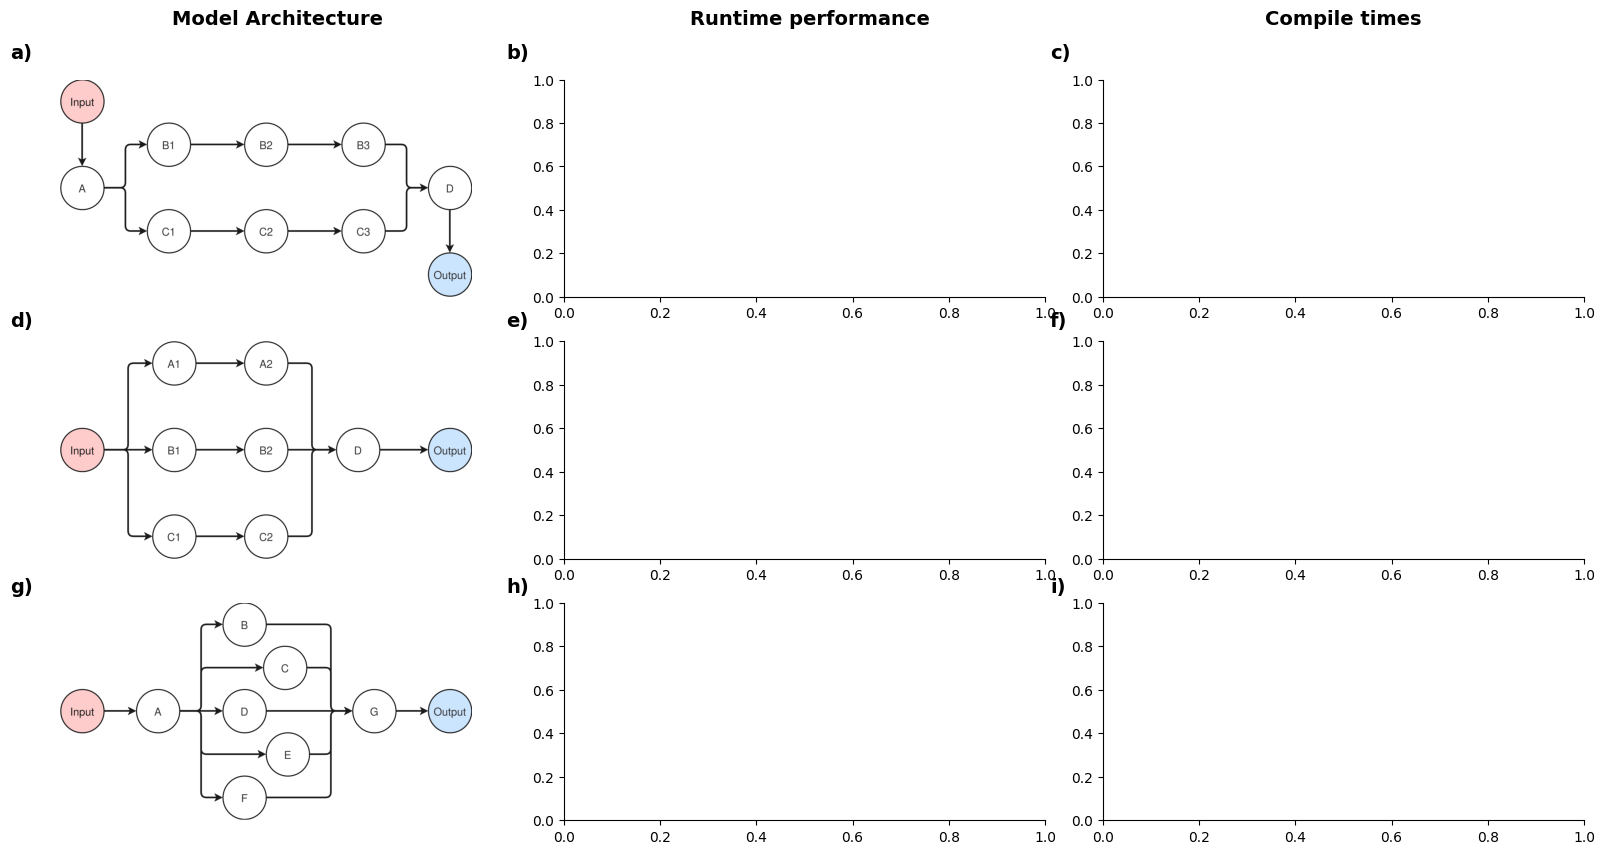

In [247]:
fig = plt.figure(figsize=(16,8), layout='tight')
gs = gridspec.GridSpec(3, 3)

for i, l in zip(range(3), ['a', 'b', 'c']):
	ax = fig.add_subplot(gs[i, 0])
	ax.imshow(plt.imread(f'./figures/diagram_{l}.png'))
	ax.set_xticks([],[])
	ax.set_yticks([],[])
	ax.axis('off')

for i, l in zip(range(3), ['a', 'b', 'c']):
	ax = fig.add_subplot(gs[i, 1])
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)

for i, l in zip(range(3), ['a', 'b', 'c']):
	ax = fig.add_subplot(gs[i, 2])
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	
fig.text(0.5-0.333, 1.05, 'Model Architecture', fontsize=14, weight='bold', horizontalalignment='center', verticalalignment='center')
fig.text(0.5, 1.05, 'Runtime performance', fontsize=14, weight='bold', horizontalalignment='center', verticalalignment='center')
fig.text(0.5+0.333, 1.05, 'Compile times', fontsize=14, weight='bold', horizontalalignment='center', verticalalignment='center')


fig.text(0, 1, 'a)', fontsize=14, weight='bold')
fig.text(0.31, 1, 'b)', fontsize=14, weight='bold')
fig.text(0.65, 1, 'c)', fontsize=14, weight='bold')
fig.text(0, 0.666, 'd)', fontsize=14, weight='bold')
fig.text(0.31, 0.666, 'e)', fontsize=14, weight='bold')
fig.text(0.65, 0.666, 'f)', fontsize=14, weight='bold')
fig.text(0, 0.333, 'g)', fontsize=14, weight='bold')
fig.text(0.31, 0.333, 'h)', fontsize=14, weight='bold')
fig.text(0.65, 0.333, 'i)', fontsize=14, weight='bold')


#ax_single_test = fig.add_subplot(gs[0, 3])
#ax_raw_train = fig.add_subplot(gs[1, 1:3])
#ax_raw_test = fig.add_subplot(gs[1, 3])
#ax_ema_train = fig.add_subplot(gs[2, 1:3])
#ax_ema_test = fig.add_subplot(gs[2, 3])
plt.tight_layout()
plt.show()

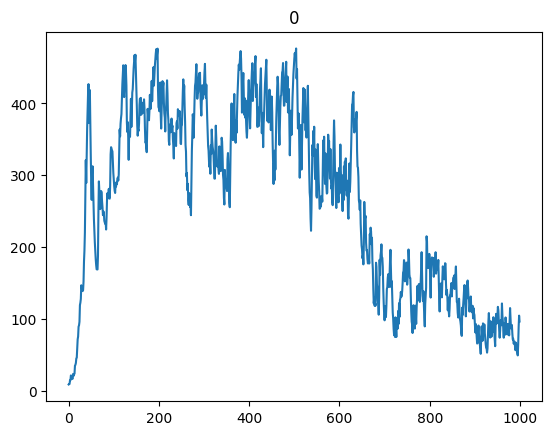

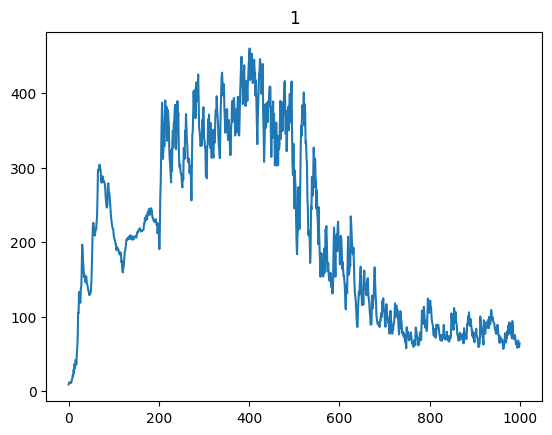

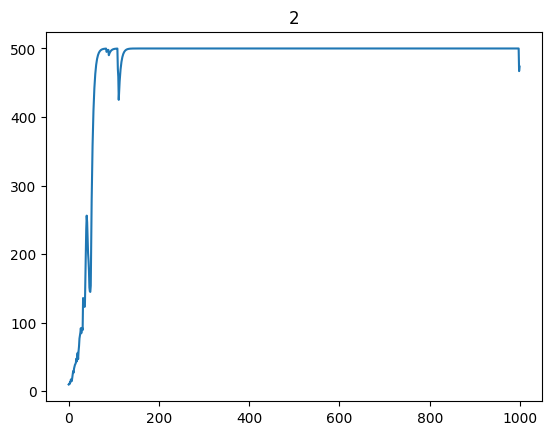

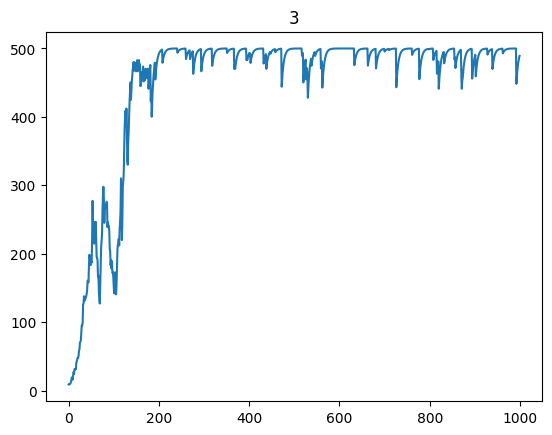

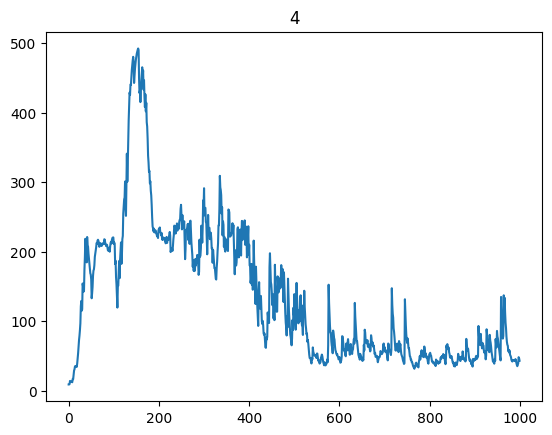

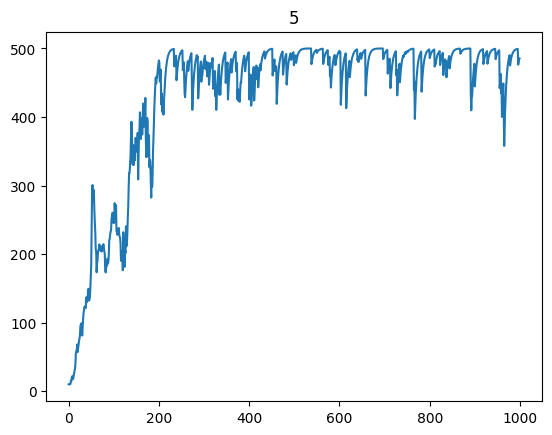

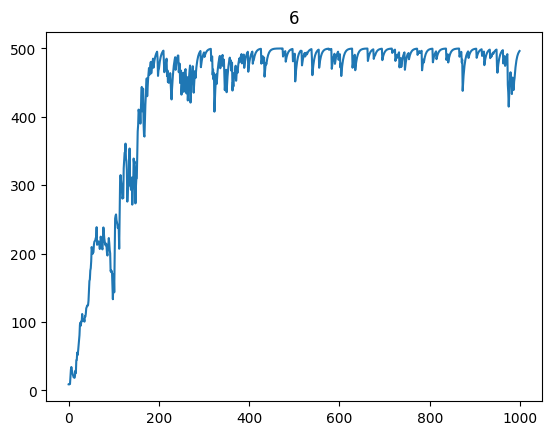

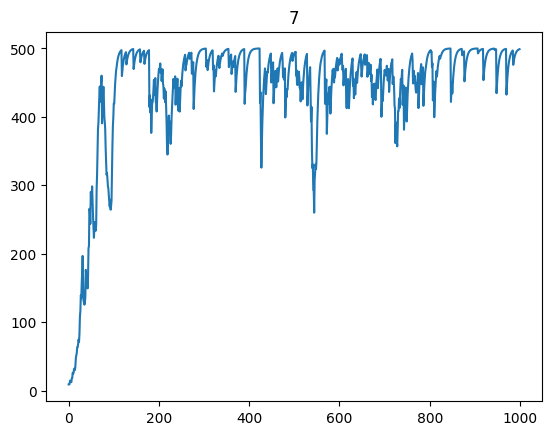

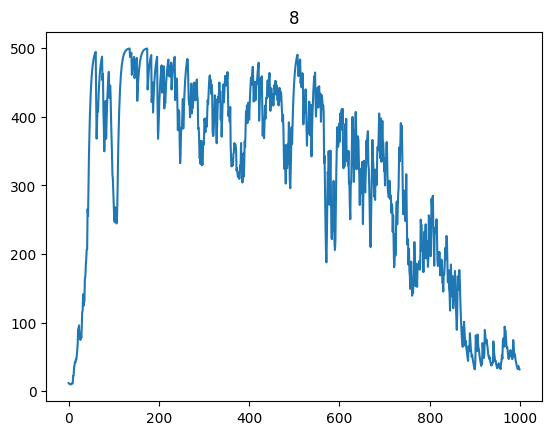

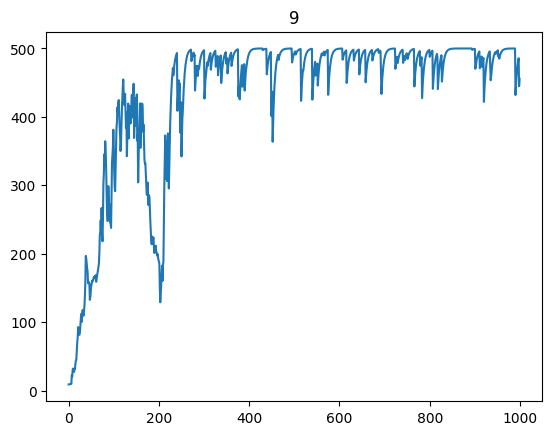

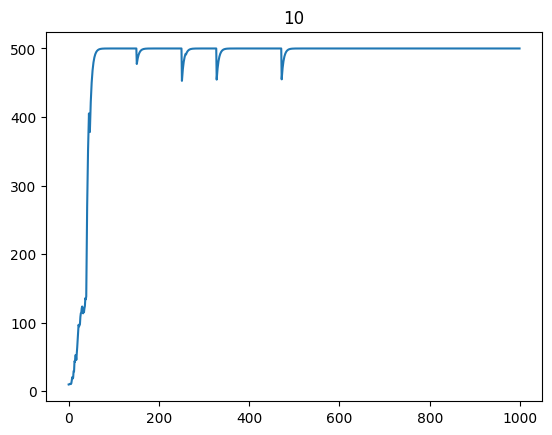

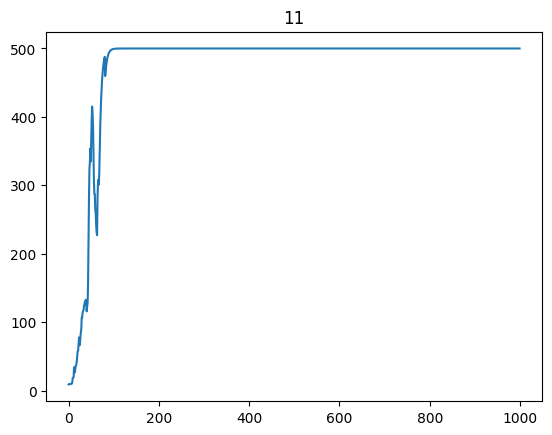

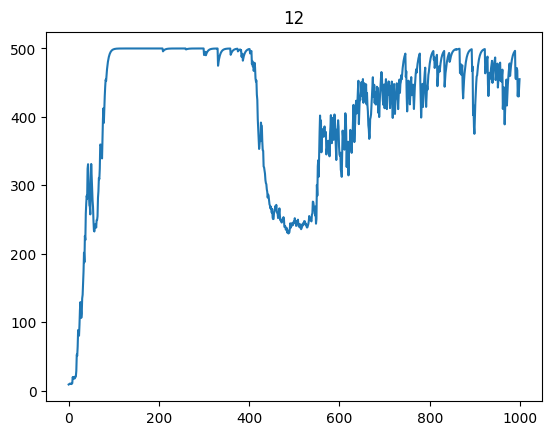

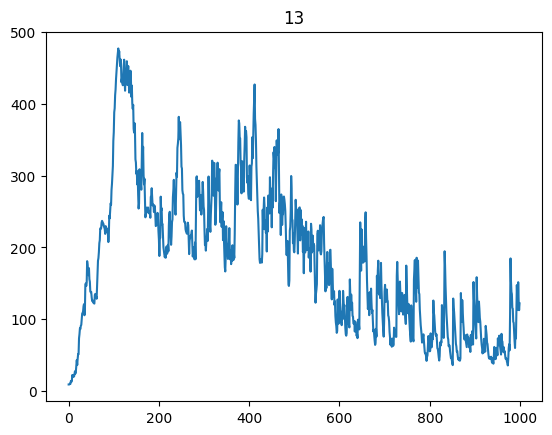

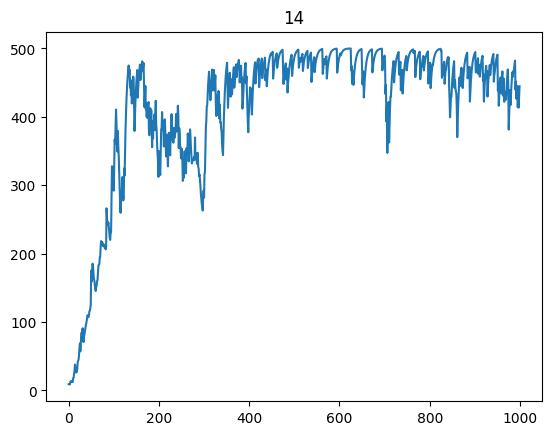

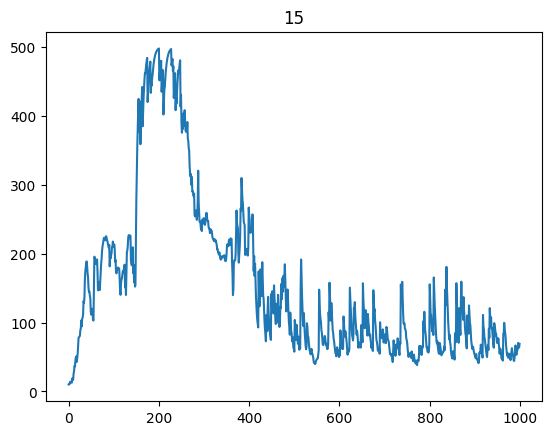

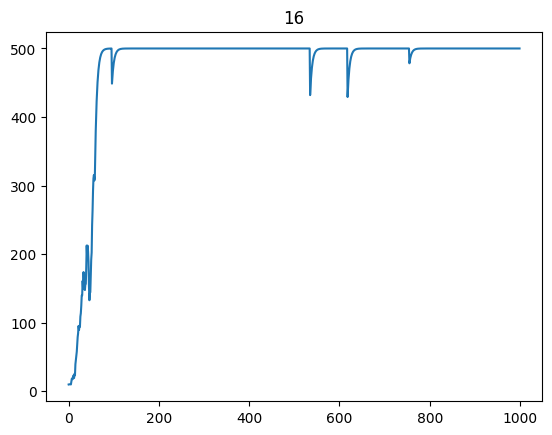

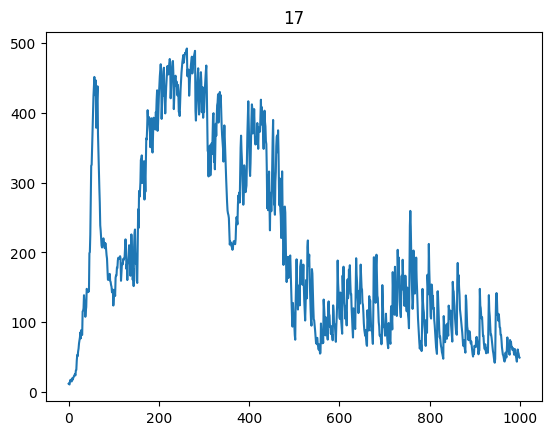

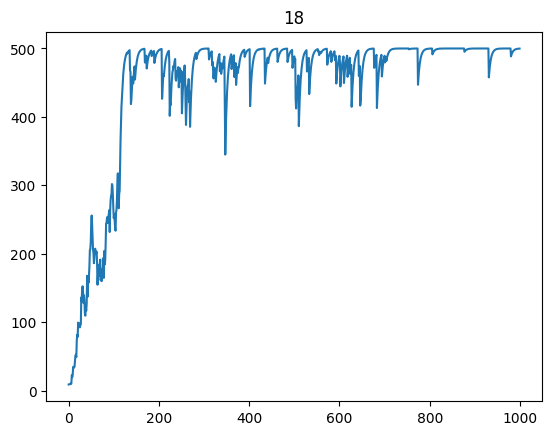

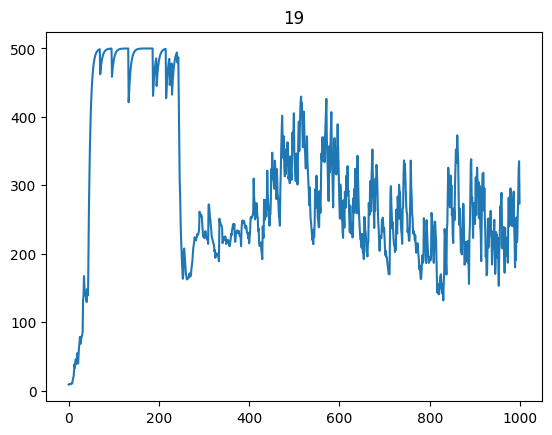

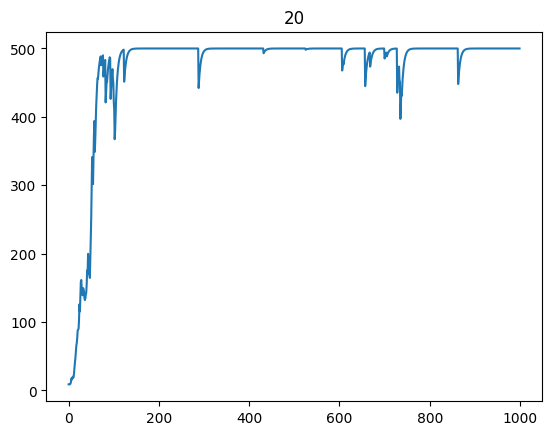

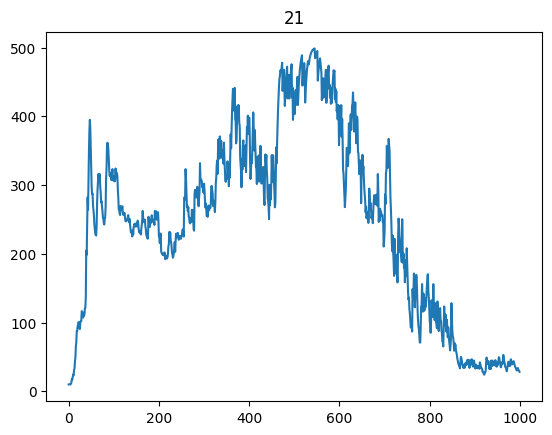

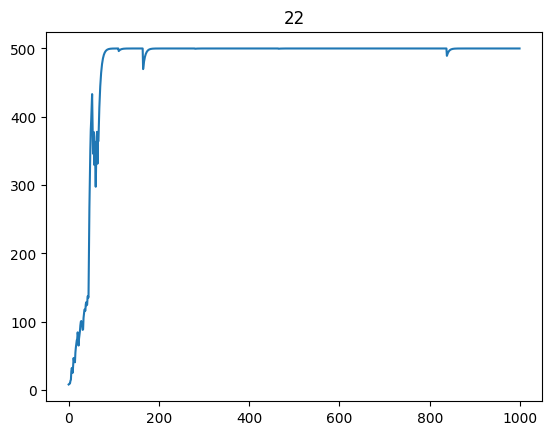

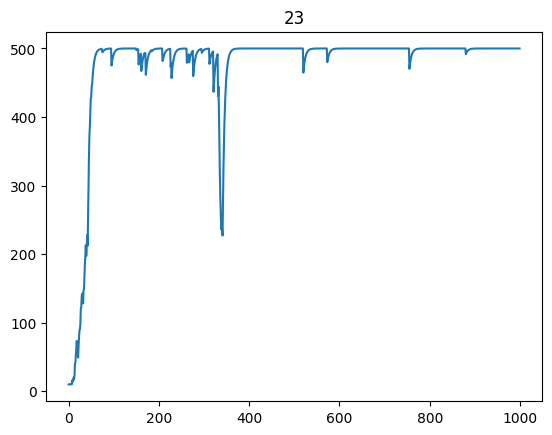

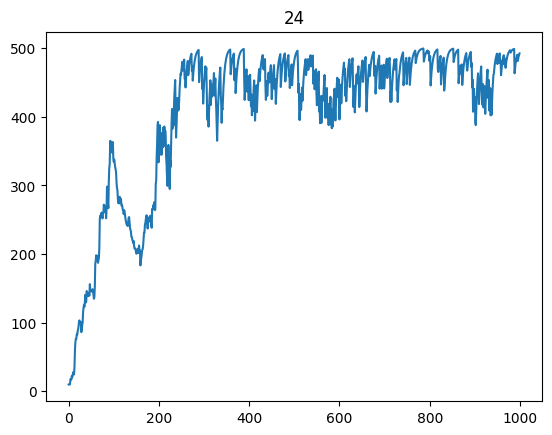

In [1]:
import numpy as np
import matplotlib
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

paths = glob.glob('./cartpole_files/mv0_1/*.npy')
paths.sort()
experiments = []
for p in paths[-25:]:
    experiments.append(np.load(p, allow_pickle=True).item())

train_steps = [exp['train_steps'] for exp in experiments]
train_steps_ema = [exp['train_steps_ema'] for exp in experiments]
train_oob = [exp['train_oob'] for exp in experiments]
test_steps = [exp['test_steps'] for exp in experiments]
test_steps_ema = [exp['test_steps_ema'] for exp in experiments]
test_oob = [exp['test_oob'] for exp in experiments]


for i, t in enumerate(train_steps_ema):
    plt.plot(t)
    plt.title(i)
    plt.show()

# Cartpole

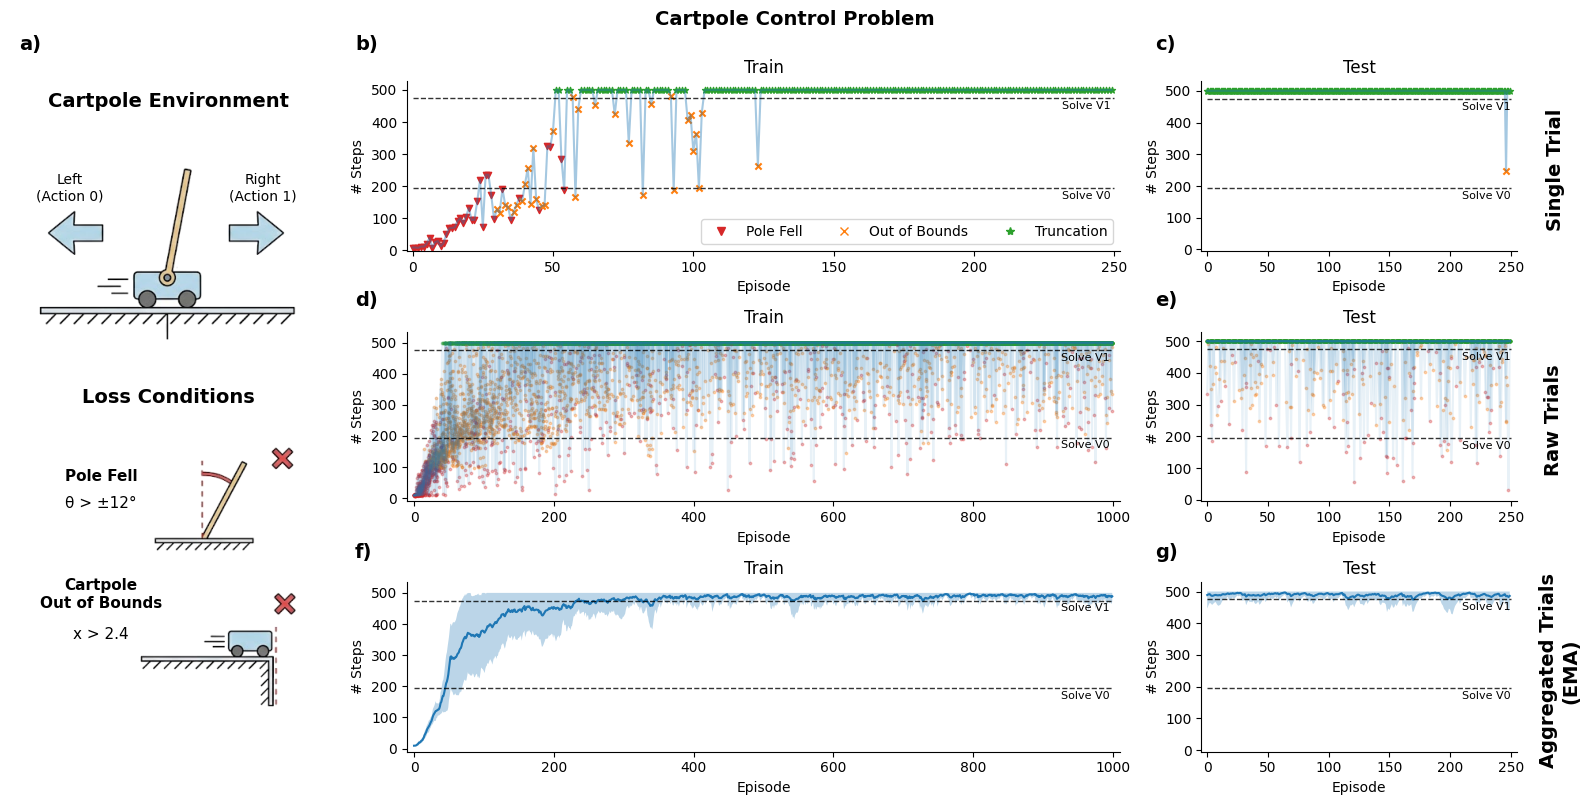

In [4]:
def populate_subplot_single(ax, y, oob, offset, title):
	x = np.arange(len(y))
	oob_mask = np.array([v in oob for v in x])
	trc_mask = np.array([v == 500 for v in y])
	fall_mask = np.logical_and(~oob_mask, ~trc_mask)
	ax.plot(x, y, color='tab:blue', alpha=0.4)
	ax.scatter(x[fall_mask], y[fall_mask], color='tab:red', s=20, alpha=1, marker='v')
	ax.scatter(x[oob_mask], y[oob_mask], color='tab:orange', s=20, alpha=1, marker='x')
	ax.scatter(x[trc_mask], y[trc_mask], color='tab:green', s=20, alpha=1, marker='*')
	ax.set_xlim(0-offset,len(y)+offset)
	ax.set_ylim(0-offset,525+offset)
	ax.set_title(title)


def populate_subplot(ax, y, oob, offset, title):
	x = np.arange(len(y))
	oob_mask = np.array([v in oob for v in x])
	trc_mask = np.array([v == 500 for v in y])
	fall_mask = np.logical_and(~oob_mask, ~trc_mask)
	ax.plot(x, y, color='tab:blue', alpha=0.1)
	ax.scatter(x[fall_mask], y[fall_mask], color='tab:red', s=3, alpha=0.3)
	ax.scatter(x[oob_mask], y[oob_mask], color='tab:orange', s=3, alpha=0.3)
	ax.scatter(x[trc_mask], y[trc_mask], color='tab:green', s=3, alpha=0.3)
	ax.set_xlim(0-offset,len(y)+offset)
	ax.set_ylim(0-offset,525+offset)
	ax.set_title(title)

def populate_subplot_ema(ax, m, s, offset, title):
	x = np.arange(len(m))
	ax.fill_between(x, np.clip(m-s, 0, 500), np.clip(m+s, 0, 500), alpha=0.3)
	ax.plot(m)
	ax.set_xlim(0-offset,len(m)+offset)
	ax.set_ylim(0-offset,525+offset)
	ax.set_title(title)


paths = glob.glob('./cartpole_files/mv0_1/*.npy')
paths.sort()
experiments = []
for p in paths[-25:]:
    experiments.append(np.load(p, allow_pickle=True).item())

train_steps = [exp['train_steps'] for exp in experiments]
train_steps_ema = [exp['train_steps_ema'] for exp in experiments]
train_oob = [exp['train_oob'] for exp in experiments]
test_steps = [exp['test_steps'] for exp in experiments]
test_steps_ema = [exp['test_steps_ema'] for exp in experiments]
test_oob = [exp['test_oob'] for exp in experiments]

sample_id = 11
filter = [2,3,5,6,7,9,10,11,14,16,18,20,22,23,24]
train_steps = [train_steps[i] for i in filter]
train_steps_ema = [train_steps_ema[i] for i in filter]
train_oob = [train_oob[i] for i in filter]
test_steps = [test_steps[i] for i in filter]
test_steps_ema = [test_steps_ema[i] for i in filter]
test_oob = [test_oob[i] for i in filter]

fig = plt.figure(figsize=(16,8), layout='tight')
gs = gridspec.GridSpec(3, 4)

ax_image = fig.add_subplot(gs[:, 0])
ax_single_train = fig.add_subplot(gs[0, 1:3])
ax_single_test = fig.add_subplot(gs[0, 3])
ax_raw_train = fig.add_subplot(gs[1, 1:3])
ax_raw_test = fig.add_subplot(gs[1, 3])
ax_ema_train = fig.add_subplot(gs[2, 1:3])
ax_ema_test = fig.add_subplot(gs[2, 3])

font = {'family' : 'sans-serif',
		#'weight' : 'bold',
		'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('figure', titlesize=14, titleweight='bold')

fig.suptitle('Cartpole Control Problem', y=1.0)

steps = 250
populate_subplot_single(ax_single_train, train_steps[sample_id][:steps], train_oob[sample_id][:steps], 2, 'Train')
populate_subplot_single(ax_single_test, test_steps[sample_id][:steps], test_oob[sample_id][:steps], 5, 'Test')

for i in range(len(train_steps)):
	populate_subplot(ax_raw_train, train_steps[i], train_oob[i], 10, 'Train')
	populate_subplot(ax_raw_test, test_steps[i], test_oob[i], 5, 'Test')

_m, _s = np.mean(train_steps_ema, axis=0), np.std(train_steps_ema, axis=0, ddof=1)
populate_subplot_ema(ax_ema_train, _m, _s, 10, 'Train')
_m, _s = np.mean(test_steps_ema, axis=0), np.std(test_steps_ema, axis=0, ddof=1), 
populate_subplot_ema(ax_ema_test, _m, _s, 5, 'Test')

for ax, max_x, offset in zip(
	[ax_single_train, ax_raw_train, ax_ema_train, ax_single_test, ax_raw_test, ax_ema_test],
	[steps] + [1000] * 2 + [steps] * 3,
	[10] + [40] * 2 + [20] * 3
	):
	ax.plot([0,max_x], [195,195], 'k--', linewidth=1, alpha=0.8)
	ax.plot([0,max_x], [475,475], 'k--', linewidth=1, alpha=0.8)
	ax.text(max_x - offset, 170, 'Solve V0', fontsize=8, horizontalalignment='center', verticalalignment='center')
	ax.text(max_x - offset, 450, 'Solve V1', fontsize=8, horizontalalignment='center', verticalalignment='center')
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.set_xlabel('Episode')
	ax.set_ylabel('# Steps')

ax_image.imshow(plt.imread('./figures/cartpole_diagram.png'))
ax_image.set_xticks([],[])
ax_image.set_yticks([],[])
ax_image.axis('off')
ax_image.text(200, 0,'Cartpole Environment', fontsize=14, weight='bold', horizontalalignment='center', verticalalignment='center')
ax_image.text(75, 110,'Left\n(Action 0)', horizontalalignment='center', verticalalignment='center')
ax_image.text(320, 110,'Right\n(Action 1)', horizontalalignment='center', verticalalignment='center')
ax_image.text(200, 375,'Loss Conditions', fontsize=14, weight='bold', horizontalalignment='center', verticalalignment='center')
ax_image.text(115, 475,'Pole Fell', fontsize=11, weight='bold', horizontalalignment='center', verticalalignment='center')
ax_image.text(115, 510,'θ > ±12°', fontsize=11, horizontalalignment='center', verticalalignment='center')
ax_image.text(115, 625,'Cartpole\nOut of Bounds', fontsize=11, weight='bold', horizontalalignment='center', verticalalignment='center')
ax_image.text(115, 675,'x > 2.4', fontsize=11, horizontalalignment='center', verticalalignment='center')

fig.text(0.015, 0.95, 'a)', fontsize=14, weight='bold')
fig.text(0.225, 0.95, 'b)', fontsize=14, weight='bold')
fig.text(0.725, 0.95, 'c)', fontsize=14, weight='bold')
fig.text(0.225, 0.63, 'd)', fontsize=14, weight='bold')
fig.text(0.725, 0.63, 'e)', fontsize=14, weight='bold')
fig.text(0.225, 0.315, 'f)', fontsize=14, weight='bold')
fig.text(0.725, 0.315, 'g)', fontsize=14, weight='bold')

legend_elements = [
	Line2D([], [], color='tab:red', marker='v', linewidth=0, label='Pole Fell'), 
	Line2D([], [], color='tab:orange', marker='x', linewidth=0, label='Out of Bounds'), 
	Line2D([], [], color='tab:green', marker='*', linewidth=0, label='Truncation'), 
]
ax_single_train.legend(handles=legend_elements, ncols=3,loc='lower right')

ax_single_test.text(int(steps * 1.15),250, 'Single Trial', fontsize=14, weight='bold', rotation=90, horizontalalignment='center', verticalalignment='center')
ax_raw_test.text(285,250, 'Raw Trials', fontsize=14, weight='bold', rotation=90, horizontalalignment='center', verticalalignment='center')
ax_ema_test.text(290,250, 'Aggregated Trials\n(EMA)', fontsize=14, weight='bold', rotation=90, horizontalalignment='center', verticalalignment='center')
plt.savefig('./figures/cartpole.png', dpi=300, bbox_inches='tight')

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2
def generate_spikes(units, t_max, dt, freq):
    steps = int(t_max / dt)
    spikes = np.random.rand(steps, units) < freq
    return spikes

def spikes_to_b2(spikes, dt):
    times, indices = np.argwhere(spikes > 0).T
    times = times * dt
    return times, indices


dt = 0.1
freq = 50 / 1000
t_max = 10
units = 5
spikes = generate_spikes(units, t_max, dt, freq)
times, indices = spikes_to_b2(spikes, dt)

In [79]:
spikes = np.random.rand(int(t_max / dt), units) < 0.1
times, indices = np.argwhere(spikes > 0).T
times = times * dt * b2.ms
indices, times
generator =  b2.SpikeGeneratorGroup(spikes.shape[-1], indices, times)

In [ ]:
import warnings
warnings.filterwarnings('ignore', message='_get_vc_env is private')

import os
os.environ['CC'] = 'gcc'
os.environ['CXX'] = 'g++'

import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import time
import tqdm


def make_adex_group(units, model_params) -> b2.NeuronGroup:
	eqs = """
		dv/dt = (-(v-v_rest) +delta_T*exp((v-v_rheobase)/delta_T) - R * w)/(tau_m) : volt
		dw/dt = (a*(v-v_rest)-w)/tau_w : amp
	"""
	group = b2.NeuronGroup(
		units,
		model=eqs, 
		reset='v=v_reset;w+=b', 
		threshold='v>firing_threshold',
		method='euler',
		namespace=model_params,
	)
	group.v = model_params['v_rest']
	return group

#-----------------------------------------------------------------------------------------------------------------------------------------------#

def connect_neuron_groups(pre, post, units, kernel=None, ker_density=0.5, synapse_strength=1.0) -> b2.Synapses:
	if kernel is None:
		kernel = synapse_strength * np.random.rand(units, units)
		kernel *= (np.random.rand(units, units) < ker_density)
	synapses = b2.Synapses(pre, post, model='w_syn : volt', on_pre='v_post += w_syn')
	src, tgt = kernel.nonzero()
	synapses.connect(i=src, j=tgt)
	synapses.w_syn = kernel[src, tgt] * b2.mV
	return synapses

#-----------------------------------------------------------------------------------------------------------------------------------------------#

def spikes_to_b2_gen(spikes, dt) -> b2.SpikeGeneratorGroup:
	times, indices = np.argwhere(spikes > 0).T
	times = times * dt
	generator =  b2.SpikeGeneratorGroup(spikes.shape[-1], indices, times)
	return generator

#-----------------------------------------------------------------------------------------------------------------------------------------------#

def run_brian_model_cpp(
		model_fn,
		sim_repetitions,
		units,
		ker_density,
		synapse_strength,
		t_max,
		dt,
		model_params,
		kernels = None,
		delete=True,
	):
	spikes = np.random.rand(int(t_max / dt), units) < 0.01
	# Start scope
	b2.set_device('cpp_standalone', build_on_run=False)
	b2.start_scope()
	b2.defaultclock.dt = dt
	compile_start = time.time()

	# Build network model 
	network = model_fn(
		spikes, 
		units, dt, 
		ker_density, 
		synapse_strength, 
		model_params,
		kernels=kernels,
	)
	network.run(t_max*b2.ms)

	# Compile model
	b2.device.build(directory='_adex_cpp', compile=True, run=False, debug=False)
	compile_end = time.time()
	compile_time = compile_end - compile_start

	# Execute model
	sim_times = []
	for _ in range(sim_repetitions):
		start = time.time()
		b2.device.run(directory='_adex_cpp', with_output=True)
		end = time.time()
		sim_times.append(end - start)

	# Clear files
	if delete:
		b2.device.delete(force=True)
	b2.device.reinit()

	return compile_time, sim_times

#-----------------------------------------------------------------------------------------------------------------------------------------------#

def run_brian_model_numpy(
		model_fn,
		sim_repetitions,
		units,
		ker_density,
		synapse_strength,
		t_max,
		sim_step,
		dt,
		model_params,
		kernels = None,
		delete=True,
	):
	spikes = np.random.rand(int(t_max / dt), units) < 0.01

	# Start scope
	b2.prefs.codegen.target = 'numpy'
	b2.set_device('runtime')
	b2.start_scope()
	b2.defaultclock.dt = dt
	compile_start = time.time()

	# Build network model 
	network = model_fn(
		spikes, 
		units, dt, 
		ker_density, 
		synapse_strength, 
		model_params,
		kernels=kernels,
	)
	#network.run(t_max*b2.ms)

	# Compile model
	# NOTE: Here compile time is just building the network object
	compile_end = time.time()
	compile_time = compile_end - compile_start

	# Execute model
	sim_times = []
	iterations = int(t_max*b2.ms / sim_step)
	print(iterations)
	for _ in range(sim_repetitions):
		start = time.time()
		for _ in range(iterations):
			network.run(sim_step)
		#network.run(t_max*b2.ms)
		end = time.time()
		sim_times.append(end - start)


	# Clear files
	if delete:
		b2.device.delete(force=True)
	b2.device.reinit()

	return compile_time, sim_times

#################################################################################################################################################
#-----------------------------------------------------------------------------------------------------------------------------------------------#
#################################################################################################################################################

def adex_model_1(spikes, units, dt, ker_density, synapse_strength, model_params, kernels: dict = {}):
	# Network model 
	layers = ('A1', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1')
	edges = [
		('input', 'A1'),
		('A1', 'B1'),
		('B1', 'B2'),
		('B2', 'B3'),
		('B3', 'D1'),
		('A1', 'C1'),
		('C1', 'C2'),
		('C2', 'C3'),
		('C3', 'D1'),
	]
	# Build neuron groups
	groups = {
		**{'input': spikes_to_b2_gen(spikes, dt)},
		**{name: make_adex_group(units, model_params) for name in layers},
	}

	# Build synapses
	synapses = [
		connect_neuron_groups(
			pre=groups[pre], 
			post=groups[post],
			units=units,
			kernel=kernels.get((pre,post), default=None) if isinstance(kernels, dict) else None, 
			ker_density=ker_density, 
			synapse_strength=synapse_strength,
		)
		for pre, post in edges
	]

	# Network
	groups_values = groups.values()
	network = b2.Network(
		*groups_values,
		*synapses
	)
	return network


UNITS = 1024
KER_DENSITY = 0.15
DT = 0.1
MEMBRANE_TIME_SCALE_TAU_M = 5.0
MEMBRANE_RESISTANCE_R = 500.0
V_REST = -70.0
V_RESET = -51.0
RHEOBASE_THRESHOLD_V_RH = -50.0
SHARPNESS_DELTA_T = 2.0
ADAPTATION_VOLTAGE_COUPLING_A = 0.5
ADAPTATION_TIME_CONSTANT_TAU_W = 10.0
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B = 5.0
FIRING_THRESHOLD_V_SPIKE = -30.0
SYNAPSE_STRENGTH = 30.0 / UNITS
T_MAX = 100.0

model_params = {
	'v_rest': V_REST * b2.mV, 
	'v_reset': V_RESET * b2.mV, 
	'v_rheobase': RHEOBASE_THRESHOLD_V_RH * b2.mV,
	'a': ADAPTATION_VOLTAGE_COUPLING_A * b2.nS, 
	'b': SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B * b2.pA, 
	'firing_threshold': FIRING_THRESHOLD_V_SPIKE * b2.mV,
	'delta_T': SHARPNESS_DELTA_T * b2.mV, 
	'tau_w': ADAPTATION_TIME_CONSTANT_TAU_W * b2.ms, 
	'tau_m': MEMBRANE_TIME_SCALE_TAU_M * b2.ms, 
	'R': MEMBRANE_RESISTANCE_R * b2.Mohm,
}


#run_brian_model_cpp(
run_brian_model_cpp_numpy(
	adex_model_1,
	sim_repetitions = 1,
	sim_step = 1 * b2.ms,
	t_max = T_MAX,
	units = UNITS,
	ker_density = KER_DENSITY,
	synapse_strength = SYNAPSE_STRENGTH,
	dt = DT * b2.ms,
	model_params=model_params,
	kernels = None,
	delete=True,
)

(6.730601787567139, [0.31721067428588867])

In [15]:
import warnings
warnings.filterwarnings('ignore', message='_get_vc_env is private')

import os
os.environ['CC'] = 'gcc'
os.environ['CXX'] = 'g++'

import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import time
import tqdm

def simulate_AdEx_model_brian(
        currents,
        t_max,
        dt,
        tau_m,
        R,
        v_rest,
        v_reset,
        v_rheobase,
        a,
        b,
        firing_threshold,
        delta_T,
        tau_w,
        delete=True,
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Simulate a AdEx neuron receiving discrete one-step current inputs from spikes.
    """
    b2.set_device('cpp_standalone', build_on_run=False)
    # Reset scope
    b2.start_scope()
    b2.defaultclock.dt = dt*b2.ms
    # Current trace
    input_current = b2.TimedArray(currents * b2.nA, dt=dt * b2.ms)
    # Build model
    eqs = """
        dv/dt = (-(v-v_rest) +delta_T*exp((v-v_rheobase)/delta_T)+ R * input_current(t) - R * w)/(tau_m) : volt
        dw/dt = (a*(v-v_rest)-w)/tau_w : amp
    """
    neuron = b2.NeuronGroup(
        1,
        model=eqs, 
        reset='v=v_reset;w+=b', 
        threshold='v>firing_threshold',
        method='rk2'
    )
    # Initialization
    neuron.v = v_rest
    neuron.w = 0.0 * b2.pA
    # Monitors
    state_monitor = b2.StateMonitor(neuron, ['v', 'w'], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    # Run simulation
    b2.run(t_max * b2.ms)
    b2.device.build(directory='_adex_cpp', compile=True, run=True, debug=False)
    # Get outputs
    times = state_monitor.t / b2.ms
    spikes = np.array([s / b2.ms for s in spike_monitor.t])
    potentials = state_monitor.v[0] / b2.mV
    adaptations = state_monitor.w[0] / b2.pA
    # Clear files
    if delete:
        b2.device.delete(force=True)
    b2.device.reinit()
    times = np.array(times).reshape(-1)
    potentials = np.array(potentials).reshape(-1)
    spikes = np.array(spikes).reshape(-1)
    return times, potentials, spikes


def ou_current(time, dt, tau, sigma, mu=0.0):
    steps = int(time / dt)
    alpha = np.exp(-dt / tau)
    noise_scale = sigma * np.sqrt(1 - alpha**2)

    I = np.empty(steps)
    I[0] = mu
    for t in range(1, steps):
        I[t] = alpha * I[t-1] + noise_scale * np.random.randn() + (1-alpha) * mu
    return I

UNITS = 1024
KER_DENSITY = 0.15
DT = 0.1
MEMBRANE_TIME_SCALE_TAU_M = 5.0
MEMBRANE_RESISTANCE_R = 500.0
V_REST = -70.0
V_RESET = -51.0
RHEOBASE_THRESHOLD_V_RH = -50.0
SHARPNESS_DELTA_T = 2.0
ADAPTATION_VOLTAGE_COUPLING_A = 0.5
ADAPTATION_TIME_CONSTANT_TAU_W = 10.0
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B = 5.0
FIRING_THRESHOLD_V_SPIKE = -30.0
SYNAPSE_STRENGTH = 30.0 / UNITS

current_fn = lambda time: 0.02*ou_current(time, DT, 10, 2, mu=1)
INPUT_CURRENTS = current_fn(100.0)
b2_times, b2_potentials, b2_spikes = simulate_AdEx_model_brian(
	currents = INPUT_CURRENTS,
	t_max = len(INPUT_CURRENTS)*DT,
	dt = DT,
	tau_m = MEMBRANE_TIME_SCALE_TAU_M * b2.ms,
	R = MEMBRANE_RESISTANCE_R * b2.Mohm,
	v_rest = V_REST * b2.mV,
	v_reset = V_RESET * b2.mV,
	v_rheobase = RHEOBASE_THRESHOLD_V_RH * b2.mV,
	a = ADAPTATION_VOLTAGE_COUPLING_A * b2.nS,
	b = SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B * b2.pA,
	firing_threshold = FIRING_THRESHOLD_V_SPIKE * b2.mV,
	delta_T = SHARPNESS_DELTA_T * b2.mV,
	tau_w = ADAPTATION_TIME_CONSTANT_TAU_W * b2.ms,
)

WARNING    The object 'neurongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_36845/1622471678.py', line 20, in make_adex_group
    group = b2.NeuronGroup( [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_36845/1622471678.py', line 20, in make_adex_group
    group = b2.NeuronGroup( [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_2' is getting deleted, but was never included in a network. This probably means that you did not store the object

In [4]:
import inspect 

def test_fn(x:int, y:float, z:bool=False) -> tuple[int, float, bool]:
	return x,y,z

def test(*abc_args, **kwargs):
	call_signature = inspect.signature(test_fn)
	print(call_signature)
	bound_args = call_signature.bind(*abc_args, **kwargs)
	print(bound_args)
	bound_args.apply_defaults()
	print(bound_args.arguments)

test(0,1.0,True)

(x: int, y: float, z: bool = False) -> tuple[int, float, bool]
<BoundArguments (x=0, y=1.0, z=True)>
{'x': 0, 'y': 1.0, 'z': True}


In [3]:
test(y=2.0, x=5)

(x: int, y: float, z: bool = False) -> tuple[int, float, bool]
<BoundArguments (x=5, y=2.0)>
<BoundArguments (x=5, y=2.0, z=False)>
